#     Explore and cluster the neighborhoods in Toronto.

  # Generate maps to visualize your neighborhoods and how they cluster together


# 
Introduction/Business Problem:

While opening a resturant can be a very lucrative business, a lack of demand causes many resturants to close within the first year of opening. There are many different factors that can account for a resturant's success such as location, competition,and quality of the food.

The goal of this project is to use the Foursquare API to determine the optimal location to open an Indian Restaurant. For Indian Restaurant specifically, location and competition are both determined by where the restaurant will be opened. If there are too many Indian Restaurants in the local vicinity, the profitability of the restaurant will be severily decreased. Additionally, starting a restaurant in a location with higher income would increase the profitability of the business over starting in a poorer area.

Business Problem: If the client wanted to open an Indian Restaurant in Toronto, what areas are the best options to open the restaurant?

Data:

I will use Foursquare API to determine the average house price in different neighborhoods (used to estimate the average income of the inhabitants), population distribution of each area, the number of Indian Restaurant in each neighborhood and the number of total restaurant in each neighborhood. The data will then be used to cluster different postal codes to determine the optimal location to open the restaurant.


In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import os
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim 
import matplotlib.cm as cm
import matplotlib.colors as colors


print('Libraries imported.')


Libraries imported.


In [2]:
List_url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(List_url).text

In [3]:
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
column_names=['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns=column_names)


In [4]:
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
        df.head()

In [5]:
df=df[df['Borough']!='Not assigned']

In [6]:
df.head()

,Postalcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [7]:
temp_df=df.groupby('Postalcode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

In [8]:
df_merge = pd.merge(df, temp_df, on='Postalcode')

In [9]:
df_merge.drop(['Neighborhood'],axis=1,inplace=True)

In [10]:
df_merge.drop_duplicates(inplace=True)

In [11]:
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)

In [12]:
df_merge.head()

,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Regent Park / Harbourfront
3,M6A,North York,Lawrence Manor / Lawrence Heights
4,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [13]:
df_merge.shape

(103, 3)

In [14]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [15]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')

In [16]:
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [17]:
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged = pd.merge(geo_df, df_merge, on='Postalcode')

In [18]:
geo_merged.head()

,Postalcode,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,Malvern / Rouge
1,M1C,43.784535,-79.160497,Scarborough,Rouge Hill / Port Union / Highland Creek
2,M1E,43.763573,-79.188711,Scarborough,Guildwood / Morningside / West Hill
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [19]:
geo_data=geo_merged[['Postalcode','Borough','Neighborhood','Latitude','Longitude']]
geo_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,Malvern / Rouge,43.806686,-79.194353
1,M1C,Scarborough,Rouge Hill / Port Union / Highland Creek,43.784535,-79.160497
2,M1E,Scarborough,Guildwood / Morningside / West Hill,43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [20]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188
42,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [21]:
CLIENT_ID = 'LRSCPQ3W3ZE2MUPG5GR25H0J451CYBEWEOPNDNHECF405KHM' # your Foursquare ID
CLIENT_SECRET = 'SDOFFYVPORBUPZLYRZ2LIGUUEQC0IYJH4FUQTRNE5PMSGEOU' # your Foursquare Secret
VERSION = '20180604'


In [22]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


The Beaches
The Danforth West / Riverdale
India Bazaar / The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park / Summerhill East
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
Roselawn
Forest Hill North & West
The Annex / North Midtown / Yorkville
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport
Stn A PO Boxes
First Canadian Place / Underground city
Christie
Dufferin / Dovercourt Village
Little Portugal / Trinity
Brockton / Parkdale Village / Exhibition Place
High Park /

In [24]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth West / Riverdale,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [25]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,18,18,18,18,18,18
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst\n Quay / South Niagara / Island airport,16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,18,18,18,18,18,18
Church and Wellesley,75,75,75,75,75,75
Commerce Court / Victoria Hotel,100,100,100,100,100,100
Davisville,32,32,32,32,32,32


In [26]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop(['Neighborhood'],axis=1,inplace=True) 
toronto_onehot.insert(loc=0, column='Neighborhood', value=toronto_venues['Neighborhood'] )
toronto_onehot.shape

(1635, 227)

In [27]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.000000,0.0,0.000000
1,Brockton / Parkdale Village / Exhibition Place,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.043478
2,Business reply mail Processing CentrE,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.055556
3,CN Tower / King and Spadina / Railway Lands / ...,0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.015625,0.0,...,0.0,0.0,0.0,0.0,0.015625,0.0,0.0,0.015625,0.0,0.015625


In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Restaurant,Beer Bar,Café,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market
1,Brockton / Parkdale Village / Exhibition Place,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Light Rail Station
3,CN Tower / King and Spadina / Railway Lands / ...,Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Bar,Plane,Sculpture Garden,Airport
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Spa,Japanese Restaurant,Ice Cream Shop,Burger Joint,Gym / Fitness Center,Bubble Tea Shop


# Making Clusters for Neighborhood

In [30]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 0, 0, 2, 0, 2, 2, 2, 0], dtype=int32)

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
41,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,2,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Restaurant,Indian Restaurant,Sports Bar,Pub
42,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,0,Fast Food Restaurant,Park,Sushi Restaurant,Movie Theater,Pet Store,Pub,Restaurant,Burrito Place,Liquor Store,Sandwich Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [32]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,Berczy Park,Coffee Shop,Cocktail Bar,Italian Restaurant,Restaurant,Beer Bar,Café,Cheese Shop,Bakery,Seafood Restaurant,Farmers Market
1,2,Brockton / Parkdale Village / Exhibition Place,Café,Breakfast Spot,Coffee Shop,Yoga Studio,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Pet Store
2,0,Business reply mail Processing CentrE,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Light Rail Station
3,0,CN Tower / King and Spadina / Railway Lands / ...,Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Bar,Plane,Sculpture Garden,Airport
4,2,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Spa,Japanese Restaurant,Ice Cream Shop,Burger Joint,Gym / Fitness Center,Bubble Tea Shop


In [34]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.6534817, -79.3839347.


# Creating the Map

In [35]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [36]:

CLIENT_ID = 'LRSCPQ3W3ZE2MUPG5GR25H0J451CYBEWEOPNDNHECF405KHM' # your Foursquare ID
CLIENT_SECRET = 'SDOFFYVPORBUPZLYRZ2LIGUUEQC0IYJH4FUQTRNE5PMSGEOU' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LRSCPQ3W3ZE2MUPG5GR25H0J451CYBEWEOPNDNHECF405KHM
CLIENT_SECRET:SDOFFYVPORBUPZLYRZ2LIGUUEQC0IYJH4FUQTRNE5PMSGEOU


In [37]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=2000
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [38]:
LIMIT=200
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )


The Beaches
The Danforth West / Riverdale
India Bazaar / The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park / Summerhill East
Summerhill West / Rathnelly / South Hill / Forest Hill SE / Deer Park
Rosedale
St. James Town / Cabbagetown
Church and Wellesley
Regent Park / Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond / Adelaide / King
Harbourfront East / Union Station / Toronto Islands
Toronto Dominion Centre / Design Exchange
Commerce Court / Victoria Hotel
Roselawn
Forest Hill North & West
The Annex / North Midtown / Yorkville
University of Toronto / Harbord
Kensington Market / Chinatown / Grange Park
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst
 Quay / South Niagara / Island airport
Stn A PO Boxes
First Canadian Place / Underground city
Christie
Dufferin / Dovercourt Village
Little Portugal / Trinity
Brockton / Parkdale Village / Exhibition Place
High Park /

In [39]:
print(toronto_venues.shape)
toronto_venues.head()

(1635, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,The Danforth West / Riverdale,43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [40]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
Brockton / Parkdale Village / Exhibition Place,23,23,23,23,23,23
Business reply mail Processing CentrE,18,18,18,18,18,18
CN Tower / King and Spadina / Railway Lands / Harbourfront West / Bathurst\n Quay / South Niagara / Island airport,16,16,16,16,16,16
Central Bay Street,64,64,64,64,64,64
Christie,18,18,18,18,18,18
Church and Wellesley,75,75,75,75,75,75
Commerce Court / Victoria Hotel,100,100,100,100,100,100
Davisville,32,32,32,32,32,32


In [41]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 227 uniques categories.


# One hot encode the unique categories

In [42]:
# one hot encoding
toronto_venues_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_venues_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_venues_onehot.columns[-1]] + list(toronto_venues_onehot.columns[:-1])
toronto_venues_onehot = toronto_venues_onehot[fixed_columns]

toronto_venues_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
toronto_venues_onehot.shape

(1635, 227)

In [44]:
toronto_venues_grouped = toronto_venues_onehot.groupby('Neighborhood').sum().reset_index()
toronto_venues_grouped


,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store
0,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Brockton / Parkdale Village / Exhibition Place,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Business reply mail Processing CentrE,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CN Tower / King and Spadina / Railway Lands / ...,0,0,1,1,1,2,3,2,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
5,Christie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Church and Wellesley,2,1,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0
7,Commerce Court / Victoria Hotel,0,0,0,0,0,0,0,0,4,...,0,0,0,0,0,2,0,0,1,0
8,Davisville,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
num_top_toronto_venues = 10

for hood in toronto_venues_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_venues_grouped[toronto_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_toronto_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop   3.0
1            Beer Bar   2.0
2  Seafood Restaurant   2.0
3      Farmers Market   2.0
4          Restaurant   2.0
5        Cocktail Bar   2.0
6              Bakery   2.0
7         Cheese Shop   2.0
8  Italian Restaurant   2.0
9                Café   2.0


----Brockton / Parkdale Village / Exhibition Place----
                    venue  freq
0                    Café   3.0
1             Coffee Shop   2.0
2          Breakfast Spot   2.0
3             Yoga Studio   1.0
4  Furniture / Home Store   1.0
5   Performing Arts Venue   1.0
6               Nightclub   1.0
7            Climbing Gym   1.0
8              Restaurant   1.0
9           Burrito Place   1.0


----Business reply mail Processing CentrE----
                  venue  freq
0           Yoga Studio   1.0
1                   Spa   1.0
2         Garden Center   1.0
3                Garden   1.0
4    Light Rail Station   1.0
5  Fast Food Restaurant   1.0
6    

                 venue  freq
0                 Café   5.0
1          Coffee Shop   5.0
2         Cocktail Bar   4.0
3                Hotel   3.0
4   Italian Restaurant   3.0
5  American Restaurant   3.0
6           Restaurant   3.0
7             Beer Bar   3.0
8  Moroccan Restaurant   2.0
9   Seafood Restaurant   2.0


----St. James Town / Cabbagetown----
                venue  freq
0         Coffee Shop   3.0
1  Italian Restaurant   2.0
2              Bakery   2.0
3         Pizza Place   2.0
4                 Pub   2.0
5          Restaurant   2.0
6                Café   2.0
7      Sandwich Place   1.0
8          Beer Store   1.0
9        Liquor Store   1.0


----Stn A PO Boxes----
                 venue  freq
0          Coffee Shop  11.0
1                 Café   4.0
2   Seafood Restaurant   4.0
3   Italian Restaurant   4.0
4           Restaurant   4.0
5                Hotel   3.0
6  Japanese Restaurant   3.0
7             Beer Bar   3.0
8       Cosmetics Shop   2.0
9               Bak

In [46]:
def return_most_common_toronto_venues(row, num_top_toronto_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_toronto_venues]


In [47]:
num_top_toronto_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_toronto_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
toronto_venues_sorted = pd.DataFrame(columns=columns)
toronto_venues_sorted['Neighborhood'] = toronto_venues_grouped['Neighborhood']
for ind in np.arange(toronto_venues_sorted.shape[0]):
    toronto_venues_sorted.iloc[ind, 1:] = return_most_common_toronto_venues(toronto_venues_grouped.iloc[ind, :], num_top_toronto_venues)

toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Italian Restaurant,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Bakery,Café
1,Brockton / Parkdale Village / Exhibition Place,Café,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym,Restaurant
2,Business reply mail Processing CentrE,Yoga Studio,Spa,Garden Center,Garden,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place
3,CN Tower / King and Spadina / Railway Lands / ...,Airport Service,Airport Lounge,Airport Terminal,Bar,Plane,Boutique,Airport,Airport Food Court,Airport Gate,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Burger Joint,Spa,Ice Cream Shop,Gym / Fitness Center,Japanese Restaurant


In [48]:
toronto_venues_grouped.columns.values.tolist()

['Neighborhood',
 'Yoga Studio',
 'Afghan Restaurant',
 'Airport',
 'Airport Food Court',
 'Airport Gate',
 'Airport Lounge',
 'Airport Service',
 'Airport Terminal',
 'American Restaurant',
 'Antique Shop',
 'Aquarium',
 'Art Gallery',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auto Workshop',
 'BBQ Joint',
 'Baby Store',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Stadium',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Store',
 'Belgian Restaurant',
 'Bistro',
 'Board Shop',
 'Boat or Ferry',
 'Bookstore',
 'Boutique',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Building',
 'Burger Joint',
 'Burrito Place',
 'Bus Line',
 'Butcher',
 'Café',
 'Cajun / Creole Restaurant',
 'Candy Store',
 'Caribbean Restaurant',
 'Cheese Shop',
 'Chinese Restaurant',
 'Chocolate Shop',
 'Church',
 'Climbing Gym',
 'Clothing Store',
 'Cocktail Bar',
 'Coffee Shop',
 'College Arts Building',
 'College Audito

# Calculate the total number of restaurants in each region

In [49]:
total_restaurants = toronto_venues_grouped['Afghan Restaurant']+toronto_venues_grouped['American Restaurant']+\
toronto_venues_grouped['Asian Restaurant']+toronto_venues_grouped['Belgian Restaurant']+toronto_venues_grouped['Airport Food Court']+\
toronto_venues_grouped['Brazilian Restaurant']+toronto_venues_grouped['Cajun / Creole Restaurant']+toronto_venues_grouped['Caribbean Restaurant']+\
toronto_venues_grouped['Chinese Restaurant']+\
toronto_venues_grouped['Colombian Restaurant']+toronto_venues_grouped['Comfort Food Restaurant']+toronto_venues_grouped['Cuban Restaurant']+\
toronto_venues_grouped['Cuban Restaurant']+toronto_venues_grouped['Doner Restaurant']+toronto_venues_grouped['Dumpling Restaurant']+\
toronto_venues_grouped['Eastern European Restaurant']+toronto_venues_grouped['Ethiopian Restaurant']+toronto_venues_grouped['Greek Restaurant']+\
toronto_venues_grouped['Indian Restaurant']+toronto_venues_grouped['Italian Restaurant']+toronto_venues_grouped['Japanese Restaurant']+\
toronto_venues_grouped['Korean Restaurant']+toronto_venues_grouped['Latin American Restaurant']+toronto_venues_grouped['Mediterranean Restaurant']+\
toronto_venues_grouped['Mexican Restaurant']+toronto_venues_grouped['Modern European Restaurant']+toronto_venues_grouped['Fried Chicken Joint']+\
toronto_venues_grouped['Molecular Gastronomy Restaurant']+toronto_venues_grouped['Moroccan Restaurant']+toronto_venues_grouped['Ramen Restaurant']+\
toronto_venues_grouped['Restaurant']+toronto_venues_grouped['Seafood Restaurant']+toronto_venues_grouped['Hotel Bar']+\
toronto_venues_grouped['Sushi Restaurant']+toronto_venues_grouped['Taiwanese Restaurant']+toronto_venues_grouped['Tapas Restaurant']+\
toronto_venues_grouped['Thai Restaurant']+toronto_venues_grouped['Theme Restaurant']+toronto_venues_grouped['Vegetarian / Vegan Restaurant']+\
toronto_venues_grouped['Vietnamese Restaurant']

In [50]:
df_restaurants = pd.DataFrame(data={'Neighborhood': toronto_venues_grouped['Neighborhood'],'Total Restaurants':total_restaurants,
                                  'Indian Restaurants':toronto_venues_grouped['Indian Restaurant']})



In [51]:
df_restaurants.head(10)

,Neighborhood,Total Restaurants,Indian Restaurants
0,Berczy Park,13,1
1,Brockton / Parkdale Village / Exhibition Place,2,0
2,Business reply mail Processing CentrE,1,0
3,CN Tower / King and Spadina / Railway Lands / ...,1,0
4,Central Bay Street,14,1
5,Christie,2,0
6,Church and Wellesley,21,1
7,Commerce Court / Victoria Hotel,28,0
8,Davisville,9,1
9,Davisville North,0,0


In [52]:
toronto_data.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188
42,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [53]:
toronto_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Farmers Market,Italian Restaurant,Restaurant,Cheese Shop,Seafood Restaurant,Beer Bar,Cocktail Bar,Bakery,Café
1,Brockton / Parkdale Village / Exhibition Place,Café,Coffee Shop,Breakfast Spot,Yoga Studio,Bakery,Performing Arts Venue,Pet Store,Convenience Store,Climbing Gym,Restaurant
2,Business reply mail Processing CentrE,Yoga Studio,Spa,Garden Center,Garden,Gym / Fitness Center,Fast Food Restaurant,Farmers Market,Light Rail Station,Comic Shop,Pizza Place
3,CN Tower / King and Spadina / Railway Lands / ...,Airport Service,Airport Lounge,Airport Terminal,Bar,Plane,Boutique,Airport,Airport Food Court,Airport Gate,Boat or Ferry
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Salad Place,Burger Joint,Spa,Ice Cream Shop,Gym / Fitness Center,Japanese Restaurant


# Combine the two dataFrames to get the final data

In [54]:
# Create the final data frame that will be analyzed using clustering
df_final = pd.merge(toronto_data,df_restaurants,on='Neighborhood')
df_final.head()


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Total Restaurants,Indian Restaurants
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0
1,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,15,1
2,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,3,0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,7,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0


In [55]:
df_final.columns.values.tolist()

['Postalcode',
 'Borough',
 'Neighborhood',
 'Latitude',
 'Longitude',
 'Total Restaurants',
 'Indian Restaurants']

In [56]:
df_final.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Total Restaurants,Indian Restaurants
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,0
1,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,15,1
2,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,3,0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,7,0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,0


Text(0, 0.5, 'Count')

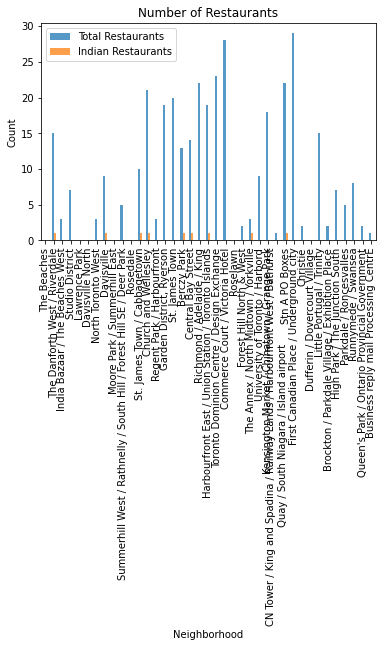

In [92]:
%matplotlib inline

ax = df_final.plot(x='Neighborhood',y=['Total Restaurants','Indian Restaurants'],kind='bar',alpha=0.75,title='Number of Restaurants')
ax.set_ylabel('Count')

# Drop columns that wont be used for clustering

# Run K-Means Clustering with K = 5

In [62]:
# add clustering labels
df_final.insert(0, 'Cluster Labels', kmeans.labels_)

In [66]:

toronto_merged.head()


,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
41,M4K,East Toronto,The Danforth West / Riverdale,43.679557,-79.352188,2,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Restaurant,Indian Restaurant,Sports Bar,Pub
42,M4L,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,0,Fast Food Restaurant,Park,Sushi Restaurant,Movie Theater,Pet Store,Pub,Restaurant,Burrito Place,Liquor Store,Sandwich Place
43,M4M,East Toronto,Studio District,43.659526,-79.340923,2,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,4,Park,Swim School,Bus Line,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,res,ires,sp in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'],toronto_merged['1st Most Common Venue'],toronto_merged['2nd Most Common Venue',toronto_merged['3rd Most Common Venue',toronto_merged['4th Most Common Venue',toronto_merged['5th Most Common Venue'],toronto_merged['6th Most Common Venue'],toronto_merged['7th Most Common Venue'],toronto_merged['8th Most Common Venue']:
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\nRestaurants: '+str(res), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

SyntaxError: invalid syntax (<ipython-input-79-b550e773d71c>, line 13)

In [80]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
42,East Toronto,India Bazaar / The Beaches West,43.668999,-79.315572,0,Fast Food Restaurant,Park,Sushi Restaurant,Movie Theater,Pet Store,Pub,Restaurant,Burrito Place,Liquor Store,Sandwich Place
45,Central Toronto,Davisville North,43.712751,-79.390197,0,Hotel,Department Store,Park,Gym,Breakfast Spot,Convenience Store,Sandwich Place,Food & Drink Shop,Dumpling Restaurant,Donut Shop
64,Central Toronto,Forest Hill North & West,43.696948,-79.411307,0,Jewelry Store,Trail,Mexican Restaurant,Sushi Restaurant,Yoga Studio,Department Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant
68,Downtown Toronto,CN Tower / King and Spadina / Railway Lands / ...,43.628947,-79.394420,0,Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Harbor / Marina,Boutique,Bar,Plane,Sculpture Garden,Airport
75,Downtown Toronto,Christie,43.669542,-79.422564,0,Grocery Store,Café,Park,Candy Store,Athletics & Sports,Baby Store,Gas Station,Coffee Shop,Nightclub,Restaurant
76,West Toronto,Dufferin / Dovercourt Village,43.669005,-79.442259,0,Bakery,Pharmacy,Supermarket,Café,Brewery,Bank,Park,Grocery Store,Pet Store,Gym / Fitness Center
82,West Toronto,High Park / The Junction South,43.661608,-79.464763,0,Mexican Restaurant,Bar,Grocery Store,Café,Thai Restaurant,Fried Chicken Joint,Flea Market,Cajun / Creole Restaurant,Speakeasy,Bakery
87,East Toronto,Business reply mail Processing CentrE,43.662744,-79.321558,0,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Restaurant,Burrito Place,Brewery,Light Rail Station


# Cluster 2

In [81]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
63,Central Toronto,1,Garden,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


# cluster 3

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
41,East Toronto,2,Greek Restaurant,Italian Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Furniture / Home Store,Restaurant,Indian Restaurant,Sports Bar,Pub
43,East Toronto,2,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
46,Central Toronto,2,Clothing Store,Coffee Shop,Yoga Studio,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Pet Store,Miscellaneous Shop
47,Central Toronto,2,Dessert Shop,Pizza Place,Sandwich Place,Gym,Italian Restaurant,Café,Sushi Restaurant,Coffee Shop,Brewery,Restaurant
49,Central Toronto,2,Pub,Coffee Shop,Fried Chicken Joint,Light Rail Station,Liquor Store,Restaurant,Sports Bar,Bank,Supermarket,Bagel Shop
51,Downtown Toronto,2,Coffee Shop,Bakery,Italian Restaurant,Café,Pub,Pizza Place,Restaurant,Chinese Restaurant,Gastropub,Convenience Store
52,Downtown Toronto,2,Coffee Shop,Japanese Restaurant,Gay Bar,Restaurant,Sushi Restaurant,Pub,Café,Gastropub,Hotel,Yoga Studio
53,Downtown Toronto,2,Coffee Shop,Park,Bakery,Pub,Mexican Restaurant,Breakfast Spot,Café,Theater,Shoe Store,Restaurant
54,Downtown Toronto,2,Coffee Shop,Clothing Store,Café,Japanese Restaurant,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Bubble Tea Shop,Electronics Store,Lingerie Store
55,Downtown Toronto,2,Café,Coffee Shop,Cocktail Bar,Italian Restaurant,Restaurant,Beer Bar,American Restaurant,Hotel,Seafood Restaurant,Park


# cluster 4

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,3,Playground,Tennis Court,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


# cluster 5

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,4,Park,Swim School,Bus Line,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
50,Downtown Toronto,4,Park,Playground,Trail,Cupcake Shop,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center,Discount Store


# Examine Cluster 4 Further

In [86]:
cluster = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(2, toronto_merged.shape[1]))]]
cluster.head(10)


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,Moore Park / Summerhill East,43.689574,-79.38316,3,Playground,Tennis Court,Yoga Studio,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster,res,ires,sp in zip(cluster['Latitude'], cluster['Longitude'], cluster['Neighborhood'], cluster['Cluster Labels'],cluster['Total Restaurants'],cluster['Indian Restaurants'],cluster['Spending Power']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '\nRestaurants: '+str(res) + '\nIndian Restaurants: '+str(ires) +'\nSpending: '+str(sp), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters